In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_columns',500)
sns.set()

# Data Import and Cleaning

## NFIRS Data

First, make sure that I import the dataset correctly and get the column dtypes correct so that data isn't lost (for id numbers with leading zeros for example)

In [2]:
nfirs_path = '../data/Master Project Data/NFIRS Fire Incident Data.csv'

cols_to_use = ['State','FDID','City','Zip','inc_date','oth_inj','oth_death','prop_loss',
               'cont_loss','tot_loss','GEOID']
col_dtypes = {'GEOID':str}

nfirs = pd.read_csv(nfirs_path,
                    dtype = col_dtypes,
                    usecols = cols_to_use,
                    encoding='latin-1')

nfirs['inc_date'] = pd.to_datetime(nfirs['inc_date'], infer_datetime_format=True)

In [3]:
# Fix the tot_loss column which had incorrect data for 2015. Since tot_loss = prop_loss + cont_loss, it was easy enough to recalculate those values
nfirs['tot_loss'] = nfirs['prop_loss'] + nfirs['cont_loss']

In [4]:
# Add the severe fire column to the dataset
sev_fire_mask = (nfirs['oth_death'] > 0) | (nfirs['oth_inj'] > 0) | (nfirs['tot_loss'] >= 10000)
nfirs['severe_fire'] = 'not_sev_fire'
nfirs.loc[sev_fire_mask,'severe_fire'] = 'sev_fire'

In [5]:
nfirs['had_inj'] = np.where(nfirs['oth_inj']>0,'had_inj','no_inj')
nfirs['had_death'] = np.where(nfirs['oth_death']>0,'had_death','no_death')
nfirs['10k_loss'] = np.where(nfirs['tot_loss']>=10000,'had_10k_loss','no_10k_loss')

In [6]:
nfirs['year'] = nfirs['inc_date'].dt.year

## Fix GEOIDs (add leading zeros to correct columns)
It seems that a lot of the GEOIDs are missing the leading 0. For now I'm just going to add a leading 0 if the GEOID length is 10.

In [7]:
nfirs['GEOID'].str.len().value_counts()

12    1503619
11     454249
Name: GEOID, dtype: int64

In [8]:
nfirs['GEOID'] = nfirs['GEOID'].str.zfill(12)

In [9]:
# Create tract column
nfirs['tract'] = nfirs['GEOID'].str[:11]

## SVI Data

In [10]:
svi2016_path = '../data/Master Project Data/SVI Tract Data.csv'
svi2016_top = pd.read_csv(svi2016_path,nrows=1000)

svi_col_dtypes = {'ST':str,'STCNTY':str,'GEOID':str}

svi2016 = pd.read_csv(svi2016_path,
                     dtype = svi_col_dtypes)

svi2016 = svi2016.rename(columns = {'GEOID':'FIPS'})
svi2016['FIPS'] = svi2016['FIPS'].str.zfill(11)

# Aggregate by Fire Department

Add fire department unique id's to the NFIRS dataframe and aggregate by fire dept unique ID

In [11]:
fire_depts = pd.read_csv('../Data/Master Project Data/Fire Station Location Data.csv')

In [12]:
fire_depts['st_fdid'] = fire_depts['STATE'] + fire_depts['FDID'].astype(str)
nfirs['st_fdid'] = nfirs['State'] + nfirs['FDID'].astype(str)

In [13]:
# join on st_fdid
nfirs = nfirs.merge(fire_depts[['st_fdid','Unique ID']].drop_duplicates(subset=['st_fdid']),how='left',on='st_fdid',validate='many_to_one')

In [14]:
nfirs['Unique ID'].isnull().sum()

1957868

## There were a huge number of rows in nfirs without a matching state & fdid in the fire_depts dataframe (~700,000)
So I decided to just look at the st_fdid from nfirs instead

In [15]:
# Zero-pad the fdid numbers to the correct length. The FDID manual suggests that this should be used
nfirs['fdid2'] = nfirs['FDID'].astype(str).str.zfill(5)
nfirs['st_fdid2'] = nfirs['State'] + nfirs['fdid2']

# Frequency table
nfirs_fdid = pd.crosstab(nfirs['st_fdid2'],[nfirs['year'],nfirs['severe_fire']])

# Add tot_fires columns
for year in [2009,2010,2011,2012,2013,2014,2015,2016]:
    nfirs_fdid[(year,'tot_fires')] = nfirs_fdid[(year,'not_sev_fire')] + nfirs_fdid[(year,'sev_fire')]
nfirs_fdid = nfirs_fdid[sorted(nfirs_fdid.columns)]

# column list to use
year_tot_fires_cols = [(year, 'tot_fires') for year in [2009,2010,2011,2012,2013,2014,2015,2016]]

In [16]:
nfirs_fdid[year_tot_fires_cols].sort_values((2009,'tot_fires'),ascending=False).head(10)

year,2009,2010,2011,2012,2013,2014,2015,2016
severe_fire,tot_fires,tot_fires,tot_fires,tot_fires,tot_fires,tot_fires,tot_fires,tot_fires
st_fdid2,,,,,,,,
NY24001.0,20730,20944,18238,17804,19884,20722,20579,20974
TX00nan,13074,14011,15748,13943,14521,15126,15063,14337
IL00nan,11375,12190,12247,11773,11693,11970,11267,10650
WA00nan,5125,4929,4928,3952,3621,3770,4199,3967
MI8207.0,3092,3307,3464,3615,3856,3547,3104,1721
MA25035.0,2791,2830,2694,2726,2812,2901,2755,3447
CA19105.0,2248,2183,2117,1546,2057,1982,1891,1155
KS00nan,1884,2154,2591,2644,2540,2835,2543,2159


In [17]:
fraction_with_zeros = (nfirs_fdid[year_tot_fires_cols] == 0).any(axis=1).sum() / nfirs_fdid.shape[0]
print('{:.3} of the fire department id’s have at least one year in which they reported 0 fires'.format(fraction_with_zeros))

0.714 of the fire department id’s have at least one year in which they reported 0 fires


## Fire Dept Data Issue - Lots of years with 0 fires reported

In [18]:
nfirs_fdid[year_tot_fires_cols][(nfirs_fdid[year_tot_fires_cols] == 0).any(axis=1)].sort_values((2009,'tot_fires'),ascending=False).head(10)

year,2009,2010,2011,2012,2013,2014,2015,2016
severe_fire,tot_fires,tot_fires,tot_fires,tot_fires,tot_fires,tot_fires,tot_fires,tot_fires
st_fdid2,,,,,,,,
GA6001.0,544,610,549,571,540,568,485,0
VA5900.0,500,642,623,368,668,637,0,737
NY34051.0,491,460,0,413,494,444,445,497
NY15100.0,440,0,212,237,242,278,0,0
CA7090.0,389,359,335,269,0,0,0,0
NJ9013.0,376,380,193,0,324,333,332,334
AL201.0,343,345,414,201,0,337,208,0
IN49009.0,314,162,354,263,87,0,0,0


In [19]:
# Ok, now that I've got the fire data aggregated by fire department, even though it is very poor, perhaps I can glean some interesting information from it.
# Aside from just data quality issues.

In [20]:
nfirs_fdid['sum_tot_fires'] = nfirs_fdid[year_tot_fires_cols].sum(axis=1)

In [21]:
(nfirs_fdid[nfirs_fdid['sum_tot_fires'] > 1000][(nfirs_fdid[year_tot_fires_cols] == 0).any(axis=1)]
 .sort_values('sum_tot_fires',ascending=False)[list(year_tot_fires_cols) + [('sum_tot_fires','')]].head(10))

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


year,2009,2010,2011,2012,2013,2014,2015,2016,sum_tot_fires
severe_fire,tot_fires,tot_fires,tot_fires,tot_fires,tot_fires,tot_fires,tot_fires,tot_fires,
st_fdid2,,,,,,,,,
PA51001.0,0,1900,1686,1866,2299,2263,1874,0,11888
CA19110.0,0,1655,1630,539,1264,1417,1454,1204,9163
VA5900.0,500,642,623,368,668,637,0,737,4175
GA6001.0,544,610,549,571,540,568,485,0,3867
NY60061.0,0,0,0,708,738,766,775,858,3845
NY34051.0,491,460,0,413,494,444,445,497,3244
CA37140.0,0,619,607,228,378,544,308,435,3119
FL3051.0,0,618,515,528,614,588,254,0,3117


## Fraction of depts reporting 0 fires each year

In [22]:
# The number of fire departments reporting 0 total fires each year
no_fire_fdids = pd.DataFrame((nfirs_fdid[year_tot_fires_cols] == 0).sum())

no_fire_fdids = no_fire_fdids.reset_index().set_index('year').drop('severe_fire',axis=1)

no_fire_fdids.columns = ['depts_with_0_fires']

no_fire_fdids['fraction_with_0_fires'] = no_fire_fdids['depts_with_0_fires'] / nfirs_fdid.shape[0]

In [23]:
no_fire_fdids

,depts_with_0_fires,fraction_with_0_fires
year,,
2009,8099,0.372865
2010,8066,0.371346
2011,7879,0.362737
2012,8196,0.377331
2013,8286,0.381474
2014,8089,0.372405
2015,7769,0.357672
2016,6651,0.306201


Text(0.5, 1.0, 'Fraction of fire departments reporting 0 fires in a given year')

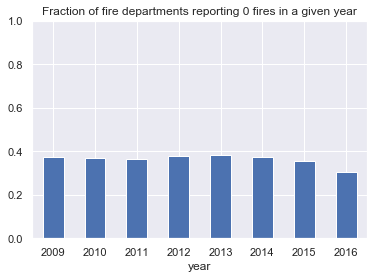

In [24]:
fig,ax = plt.subplots()
no_fire_fdids['fraction_with_0_fires'].plot.bar(ax=ax,rot=0)
ax.set_ylim((0,1))
ax.set_title('Fraction of fire departments reporting 0 fires in a given year')

In [25]:
# The fraction of fire departments which reported fewer than 10 fires during the whole time period. This suggests that a large 
# fraction of the fire departments are smaller & deal with a small amount of fires over time.
(nfirs_fdid['sum_tot_fires'] < 10).sum() / nfirs_fdid.shape[0]

0.3656829796049906

Text(0.5, 1.0, 'Histogram of total number of fires reported in NFIRS by a given fire department')

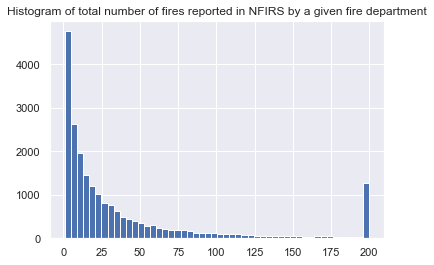

In [26]:
fig,ax = plt.subplots()
nfirs_fdid['sum_tot_fires'].clip(0,200).hist(bins = 50,ax=ax)
ax.set_title('Histogram of total number of fires reported in NFIRS by a given fire department')

## Finding reliable districts

In [27]:
from scipy import stats

In [28]:
df = nfirs_fdid.loc[:,(slice(2009,2016),'tot_fires')].copy()
df.columns = list(range(2009,2017))

df['zero_years'] = (df==0).sum(axis=1)
df['sum_tot_fires'] = df.loc[:,range(2009,2017)].sum(axis=1)
df['std'] = df[range(2009,2017)].std(axis=1)
df['variation'] = stats.variation(df[range(2009,2017)],axis=1)

df = df.reset_index()
df['state'] = df['st_fdid2'].str[:2]
df = df.set_index('st_fdid2')

In [29]:
df.head()

,2009,2010,2011,2012,2013,2014,2015,2016,zero_years,sum_tot_fires,std,variation,state
st_fdid2,,,,,,,,,,,,,
AK11100.0,30,31,34,43,29,34,27,31,0,259,4.897157,0.141494,AK
AK12100.0,1,3,5,6,4,3,4,0,1,26,1.982062,0.570477,AK
AK12111.0,0,0,0,0,0,0,1,0,7,1,0.353553,2.645751,AK
AK12150.0,1,0,2,0,1,1,0,0,4,5,0.744024,1.113553,AK
AK12151.0,0,0,0,0,0,1,0,0,7,1,0.353553,2.645751,AK


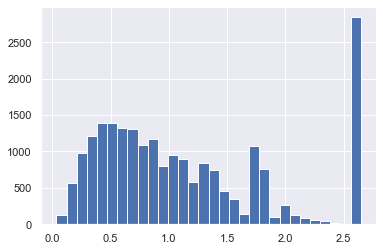

In [30]:
df['variation'].hist(bins=30)

In [31]:
df[df['zero_years']==1].sort_values('variation',ascending=False)

,2009,2010,2011,2012,2013,2014,2015,2016,zero_years,sum_tot_fires,std,variation,state
st_fdid2,,,,,,,,,,,,,
NY14024.0,0,17,9,6,11,33,63,407,1,546,138.341968,1.896074,NY
NJ2230.0,0,21,8,2,2,2,8,121,1,164,41.161702,1.878207,NJ
WV30109.0,0,4,1,1,5,1,1,35,1,48,11.844227,1.846543,WV
VA13700.0,2,5,0,2,1,1,1,23,1,35,7.670677,1.640060,VA
TN82121.0,0,2,1,2,3,1,1,17,1,27,5.578978,1.546269,TN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
GA6001.0,544,610,549,571,540,568,485,0,1,3867,198.464058,0.384062,GA
NY34051.0,491,460,0,413,494,444,445,497,1,3244,166.482088,0.384044,NY
MI1702.0,1,1,1,0,1,1,1,1,1,7,0.353553,0.377964,MI


In [32]:
df['zero_years'].value_counts()

0    6204
7    2841
1    2601
6    2203
2    2079
3    1990
5    1989
4    1814
Name: zero_years, dtype: int64

In [33]:
test = df.groupby('state')

In [34]:
df.groupby('state').mean()[['zero_years','variation']].sort_values('variation').head()

,zero_years,variation
state,,
DC,0.000000,0.353476
MA,0.956044,0.602167
OH,1.144509,0.658341
HI,1.600000,0.698401
CT,1.278226,0.703686
